In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Apr 15 00:50:45 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   43C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [4]:

!pip -qqq install pydub
!pip -qqq install tensorboard
!pip -qqq install visualkeras
!pip -qqq install --upgrade keras
!pip -qqq install --upgrade keras tensorflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.4/997.4 kB 50.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 60.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 109.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 116.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, but you have tensorflow 2.19.0 which is incompatible.
tf-keras 2.18.0 requires tensorflow<2.19,>=2.18, but you have tensorflow 2.19.0 which is incompatible.
tensorflow-decision-forests 1.11.0 requires tensorflow==2.18.0, but you have tensorflow 2.19.0 which is incompatible.


**#NEW VERSIONS**

In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix




In [8]:
# -----------------------------
# 📁 CONFIGURATION
# -----------------------------
base_dir = '/content/drive/MyDrive/ASE_Dataset_Folder'
image_dir = os.path.join(base_dir, 'Mel_Images_1_Sec')
train_dir = os.path.join(image_dir, 'Train/Sounds')
test_dir = os.path.join(image_dir, 'Test/Sounds')

num_classes = 13
height = 128
n_fft = 2048
hop_length = 256
sr = 22050
T = 1  # seconds
channels = 3
batch_size = 32
epochs = 180

hop_size_sec = hop_length / sr
audio_length_samples = T * sr
width = 1 + int((audio_length_samples - n_fft) / hop_length)

In [9]:


# -----------------------------
# 📦 DATA GENERATORS
# -----------------------------
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(height, width),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(height, width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)


Found 3015 images belonging to 13 classes.
Found 1351 images belonging to 13 classes.


In [10]:

# -----------------------------
# 🧠 RNN MODEL
# -----------------------------
model = tf.keras.Sequential([
    layers.Reshape((width, height * channels), input_shape=(height, width, channels)),
    layers.Bidirectional(layers.LSTM(32, activation='relu', return_sequences=True)),
    layers.BatchNormalization(),
    layers.Bidirectional(layers.LSTM(32, activation='relu')),
    layers.BatchNormalization(),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [11]:

# -----------------------------
# 📈 TRAINING LOOP + METRICS
# -----------------------------
metrics_data = []

for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=1,
        validation_data=test_generator,
        validation_steps=len(test_generator),
        verbose=1
    )

    train_acc = history.history['accuracy'][0]
    val_acc = history.history['val_accuracy'][0]
    metrics_data.append([epoch + 1, train_acc, val_acc])
    print(f"Train Accuracy: {train_acc:.4f}, Val Accuracy: {val_acc:.4f}")
    print(f"Train Loss: {history.history['loss'][0]:.4f}, Val Loss: {history.history['val_loss'][0]:.4f}")

    model_path = '/content/drive/MyDrive/RNN/Mel_RNN/al-emadi_rnn_MEL_standardized_test.keras'
    model.save(model_path)
    print(f"✅ Model saved to: {model_path}")







Epoch 1/180


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


95/95 ━━━━━━━━━━━━━━━━━━━━ 3314s 35s/step - accuracy: 0.1330 - loss: 2.7283 - val_accuracy: 0.1540 - val_loss: 2.3908
Train Accuracy: 0.1871, Val Accuracy: 0.1540
Train Loss: 2.5721, Val Loss: 2.3908
✅ Model saved to: /content/drive/MyDrive/RNN/Mel_RNN/al-emadi_rnn_MEL_standardized_test.keras

Epoch 2/180
95/95 ━━━━━━━━━━━━━━━━━━━━ 50s 531ms/step - accuracy: 0.3757 - loss: 2.0411 - val_accuracy: 0.2028 - val_loss: 2.2933
Train Accuracy: 0.3924, Val Accuracy: 0.2028
Train Loss: 1.9924, Val Loss: 2.2933
✅ Model saved to: /content/drive/MyDrive/RNN/Mel_RNN/al-emadi_rnn_MEL_standardized_test.keras

Epoch 3/180
95/95 ━━━━━━━━━━━━━━━━━━━━ 50s 532ms/step - accuracy: 0.4366 - loss: 1.8368 - val_accuracy: 0.2805 - val_loss: 2.1551
Train Accuracy: 0.4381, Val Accuracy: 0.2805
Train Loss: 1.8174, Val Loss: 2.1551
✅ Model saved to: /content/drive/MyDrive/RNN/Mel_RNN/al-emadi_rnn_MEL_standardized_test.keras

Epoch 4/180
95/95 ━━━━━━━━━━━━━━━━━━━━ 50s 523ms/step - accuracy: 0.4295 - loss: 1.8017 - v

In [12]:
# Save metrics to CSV
metrics_df = pd.DataFrame(metrics_data, columns=['Epoch', 'Train Accuracy', 'Validation Accuracy'])
metrics_path = '/content/drive/MyDrive/RNN/Mel_RNN/metrics.csv'
metrics_df.to_csv(metrics_path, index=False)
print(f"\n✅ Training metrics saved to: {metrics_path}")




✅ Training metrics saved to: /content/drive/MyDrive/RNN/Mel_RNN/metrics.csv


In [13]:
# Assuming you want to read the CSV file
import pandas as pd

# Replace with the actual path to your metrics.csv file
metrics_path = r'/content/drive/MyDrive/RNN/Mel_RNN/metrics.csv'
metrics_df = pd.read_csv(metrics_path)  # Read the CSV into a DataFrame


In [ ]:
# Save trained model
model_path = '/content/drive/MyDrive/RNN/Mel_RNN/al-emadi_rnn_MEL_standardized_test.keras'


In [ ]:
model.save(model_path)
print(f"✅ Model saved to: {model_path}")

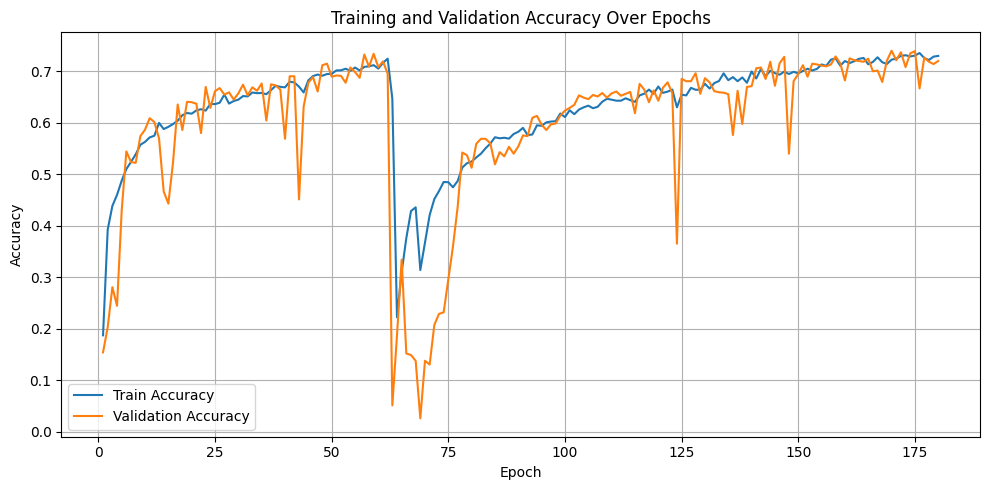

In [14]:

# -----------------------------
# 📊 PLOT ACCURACY OVER EPOCHS
# -----------------------------
plt.figure(figsize=(10, 5))
plt.plot(metrics_df['Epoch'], metrics_df['Train Accuracy'], label='Train Accuracy')
plt.plot(metrics_df['Epoch'], metrics_df['Validation Accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Found 1351 images belonging to 13 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


43/43 ━━━━━━━━━━━━━━━━━━━━ 17s 340ms/step - accuracy: 0.6870 - loss: 0.9257

🧪 Test Loss: 0.8227
🧪 Test Accuracy: 0.7195
43/43 ━━━━━━━━━━━━━━━━━━━━ 16s 336ms/step

📄 Classification Report:
                   precision    recall  f1-score   support

      Dam Failure       1.00      0.23      0.38        13
       Earthquake       0.60      0.78      0.68       185
  Emergency_alarm       0.83      0.77      0.80       124
        Explosion       0.90      0.12      0.20        78
            Flood       0.63      0.82      0.71        76
        Gun_Shots       0.54      0.89      0.67        35
          Tsunami       0.70      0.29      0.41        89
Volcanic Eruption       0.59      0.52      0.56       111
         Wildfire       0.98      0.97      0.98       400
              dog       0.78      0.64      0.71        56
   glass_breaking       0.55      0.93      0.69        60
     thunderstorm       0.42      0.48      0.45        58
             wind       0.40      0.50     

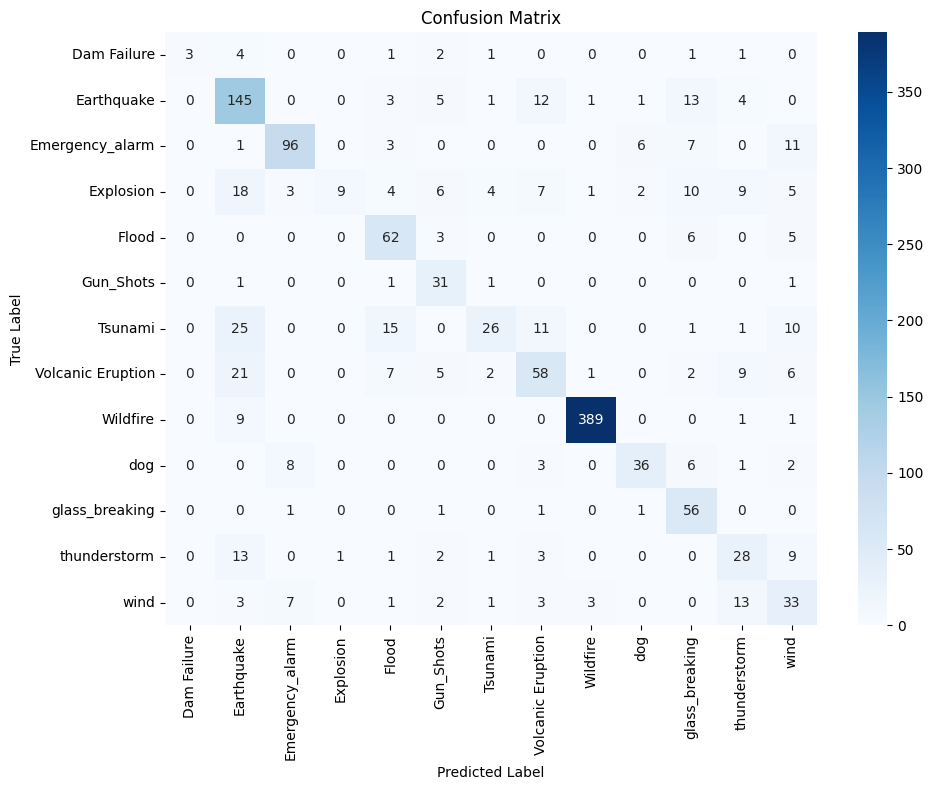

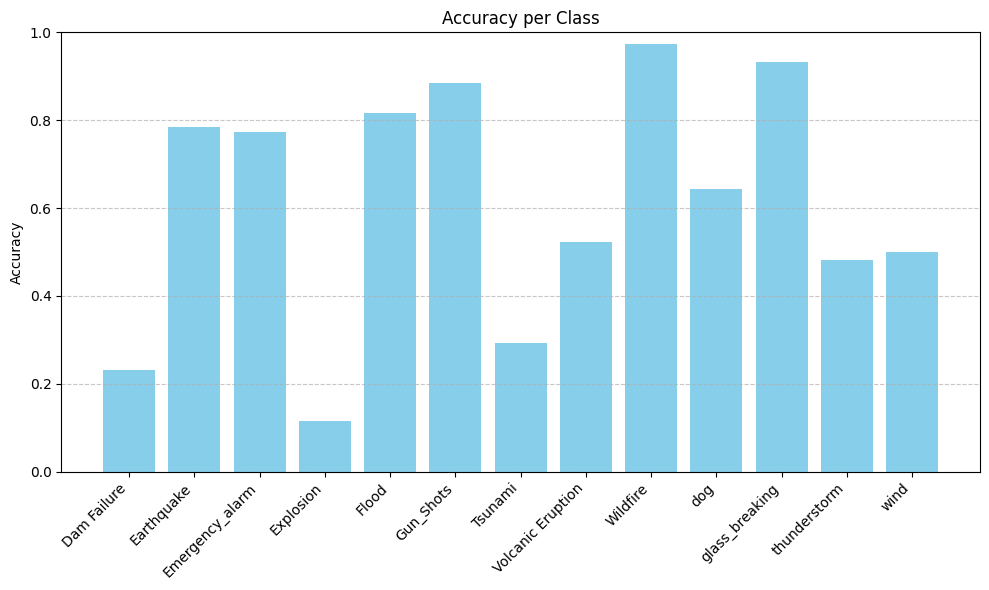

In [16]:
# -----------------------------
# 📉 EVALUATE MODEL
# -----------------------------
import tensorflow as tf # Import TensorFlow
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Import ImageDataGenerator
import numpy as np # Import NumPy

model = tf.keras.models.load_model(model_path)

# -----------------------------
# Re-define test_generator
# -----------------------------
base_dir = '/content/drive/MyDrive/ASE_Dataset_Folder'
image_dir = os.path.join(base_dir, 'Mel_Images_1_Sec')
test_dir = os.path.join(image_dir, 'Test/Sounds')
num_classes = 13
height = 128
n_fft = 2048
hop_length = 256
sr = 22050
T = 1  # seconds
channels = 3
batch_size = 32
epochs = 180

hop_size_sec = hop_length / sr
audio_length_samples = T * sr
width = 1 + int((audio_length_samples - n_fft) / hop_length)


test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(height, width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)





# -----------------------------
# 📉 EVALUATE MODEL
# -----------------------------

loss, accuracy = model.evaluate(test_generator)
print(f"\n🧪 Test Loss: {loss:.4f}")
print(f"🧪 Test Accuracy: {accuracy:.4f}")

# -----------------------------
# 🔮 PREDICTIONS
# -----------------------------
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# -----------------------------
# 🧾 CLASSIFICATION REPORT
# -----------------------------
print("\n📄 Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# -----------------------------
# 📌 PER-CLASS ACCURACY
# -----------------------------
class_accuracy = {}
for i, label in enumerate(class_labels):
    idxs = np.where(true_classes == i)[0]
    correct = np.sum(predicted_classes[idxs] == i)
    total = len(idxs)
    class_accuracy[label] = correct / total if total > 0 else 0.0

print("\n🎯 Accuracy per Class:")
for label in class_labels:
    print(f"{label}: {class_accuracy[label]:.4f}")

# -----------------------------
# 🔥 CONFUSION MATRIX HEATMAP
# -----------------------------
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# -----------------------------
# 📊 PER-CLASS ACCURACY BAR PLOT
# -----------------------------
plt.figure(figsize=(10, 6))
plt.bar(class_accuracy.keys(), class_accuracy.values(), color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Accuracy per Class')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Found 1351 images belonging to 13 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


43/43 ━━━━━━━━━━━━━━━━━━━━ 813s 19s/step - accuracy: 0.1114 - loss: 7.6436

🧪 Test Loss: 10.5387
🧪 Test Accuracy: 0.1273
43/43 ━━━━━━━━━━━━━━━━━━━━ 16s 345ms/step

📄 Classification Report:
                   precision    recall  f1-score   support

      Dam Failure       0.00      0.00      0.00        13
       Earthquake       1.00      0.01      0.01       185
  Emergency_alarm       0.72      0.52      0.61       124
        Explosion       0.07      0.05      0.06        78
            Flood       0.07      0.26      0.11        76
        Gun_Shots       0.03      0.03      0.03        35
          Tsunami       0.05      0.06      0.05        89
Volcanic Eruption       0.00      0.00      0.00       111
         Wildfire       0.00      0.00      0.00       400
              dog       0.83      0.18      0.29        56
   glass_breaking       0.58      0.82      0.68        60
     thunderstorm       0.00      0.00      0.00        58
             wind       0.03      0.26     

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


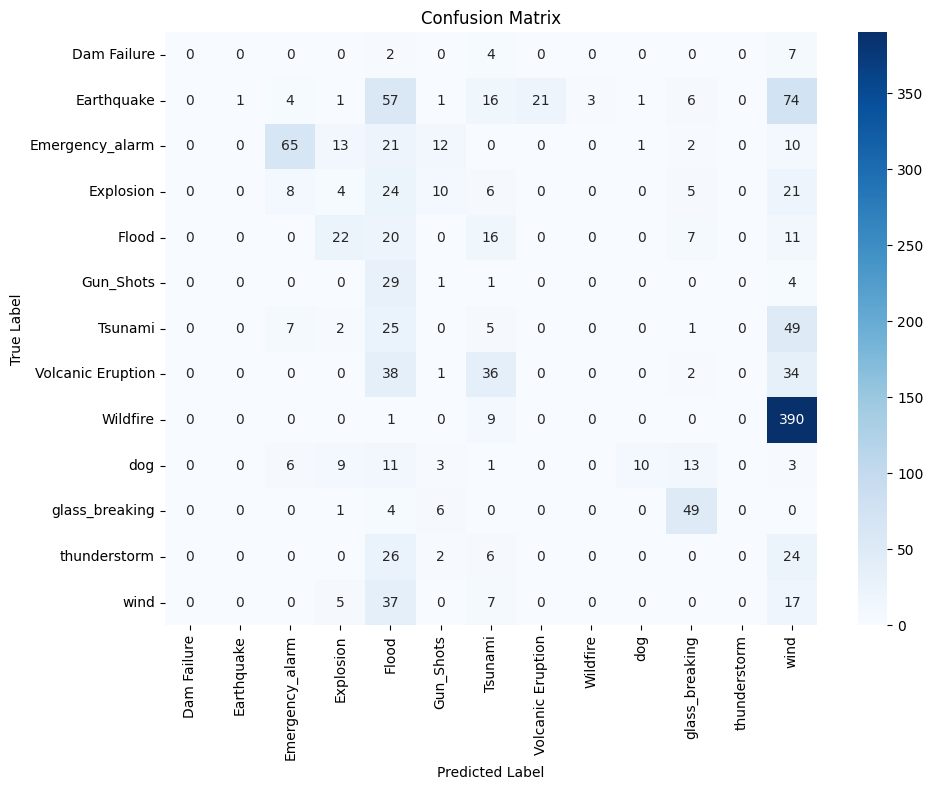

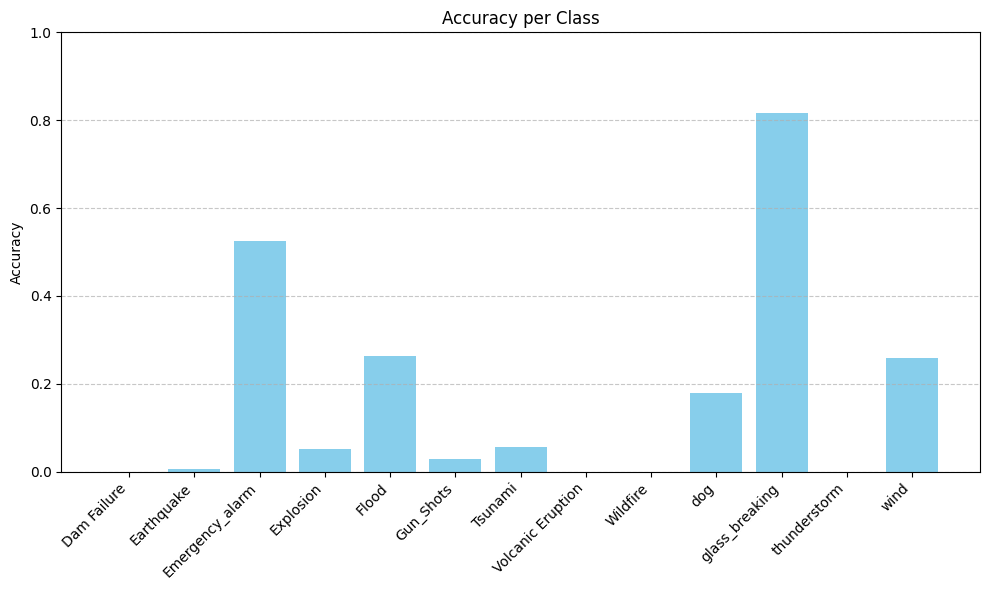

In [15]:
#checking with STFT


# -----------------------------
# 📉 EVALUATE MODEL
# -----------------------------
import tensorflow as tf # Import TensorFlow
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Import ImageDataGenerator
import numpy as np # Import NumPy

model = tf.keras.models.load_model(model_path)

# -----------------------------
# Re-define test_generator
# -----------------------------
base_dir = '/content/drive/MyDrive/ASE_Dataset_Folder'
image_dir = os.path.join(base_dir, 'STFT_Images_1_Sec')
test_dir = os.path.join(image_dir, 'Test/Sounds')
num_classes = 13
height = 128
n_fft = 2048
hop_length = 256
sr = 22050
T = 1  # seconds
channels = 3
batch_size = 32
epochs = 180

hop_size_sec = hop_length / sr
audio_length_samples = T * sr
width = 1 + int((audio_length_samples - n_fft) / hop_length)


test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(height, width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)





# -----------------------------
# 📉 EVALUATE MODEL
# -----------------------------

loss, accuracy = model.evaluate(test_generator)
print(f"\n🧪 Test Loss: {loss:.4f}")
print(f"🧪 Test Accuracy: {accuracy:.4f}")

# -----------------------------
# 🔮 PREDICTIONS
# -----------------------------
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# -----------------------------
# 🧾 CLASSIFICATION REPORT
# -----------------------------
print("\n📄 Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# -----------------------------
# 📌 PER-CLASS ACCURACY
# -----------------------------
class_accuracy = {}
for i, label in enumerate(class_labels):
    idxs = np.where(true_classes == i)[0]
    correct = np.sum(predicted_classes[idxs] == i)
    total = len(idxs)
    class_accuracy[label] = correct / total if total > 0 else 0.0

print("\n🎯 Accuracy per Class:")
for label in class_labels:
    print(f"{label}: {class_accuracy[label]:.4f}")

# -----------------------------
# 🔥 CONFUSION MATRIX HEATMAP
# -----------------------------
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# -----------------------------
# 📊 PER-CLASS ACCURACY BAR PLOT
# -----------------------------
plt.figure(figsize=(10, 6))
plt.bar(class_accuracy.keys(), class_accuracy.values(), color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Accuracy per Class')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
